# Определение стоимости автомобилей

<b>Описание проекта</b>

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.

<b>Цель проекта</b>

В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

<b>Задачи проекта</b>

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<b>Разделим наш проект на этапы:</b>

1. Подготовка данных

    [ Загрузка необходимых библиотек](#step_1)
    
    [ Загрузка данных, их анализ и предобработка](#step_2)

[2. Обучение моделей](#step_3)

   [ Обучение модели линейной регрессии](#step_4)
   
   [ Обучение модели дерева решений](#step_5)
   
   [ Обучение модели случайного дерева](#step_6)
   
   [ Обучение модели CatBoostRegressor](#step_7)
   
   [ Обучение модели LGBMRegressor](#step_8)
   
   [ Выод по данному этапу](#step_9)

[3. Анализ моделей](#step_10)

[4. Общий вывод](#step_11)

## Подготовка данных

<a id="step_1"></a>
Загрузим необходимые библиотеки

In [1]:
import pandas as pd # для работы с данными
from sklearn.model_selection import train_test_split # для разбиения данных на выборки
from sklearn.preprocessing import StandardScaler # для маштабирования данных
from sklearn.metrics import mean_squared_error # для расчета MSE и RMSE
from sklearn.metrics import make_scorer # для генерации объекта скоринга
from sklearn.model_selection import GridSearchCV # для получения наилучших параметров модели
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import time

<a id="step_2"></a>
Загрузим наши данные

In [2]:
try:
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

Функция для первичного просмотра загруженных данных

In [3]:
def first_look (df: pd.DataFrame, limit_na_category: int = 10) -> None:
    '''Функция получения первичной информации о датафрейме'''
    print ('------------- Первые 5 строк ------------')
    display(df.head())
    print('')
    print('')
    print ('------------- Типы данных ------------')
    print (df.info())
    print('')
    print('')
    print ('------------- Пропуски ------------')
    count = 0
    shape_0 = df.shape[0]
    for element in df.columns:
        if df[element].isna().sum() > 0:
            print(element, ' - ', df[element].isna().sum(), 'пропусков, ', round(df[element].isna().sum() * 100 / shape_0,2),\
                  '% от числа строк.' )
            count = +1
    if count == 0:
        print('Пропусков НЕТ')
        print('')
        print('')
    print ('------------- Дубликаты ------------')
    if df.duplicated().sum() > 0:
        print('Дубликатов: ', df.duplicated().sum())
    else:
        print('Дубликатов НЕТ')
    # ищем, есть ли категориальные столбцы (содержащие до limit_na_category уникальных значений) в датафрейме
    min_unique = limit_na_category + 1
    for element in df.columns:
        min_unique = min(min_unique, df[element].nunique())
        if min_unique <= limit_na_category:
            print('')
    print('')
    print('------------- Категориальные признаки ------------')
    for element in df.columns:
        if df[element].nunique() <= limit_na_category:
            print(element, ': ', df[element].nunique(), 'категории - ', df[element].unique(), )

Посмотрим на наши данные

In [4]:
first_look(df)

------------- Первые 5 строк ------------


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 n

Наши данные представляют из себя таблицу из 16 столбцов и 354 369 строк, из которых:

Признаки

•	DateCrawled — дата скачивания анкеты из базы (без пропусков данных)

•	VehicleType — тип автомобильного кузова (37 490 строк пропусков)

•	RegistrationYear — год регистрации автомобиля

•	Gearbox — тип коробки передач (19 833 строк пропусков)

•	Power — мощность (л. с.)

•	Model — модель автомобиля (19 705 строк пропусков)

•	Kilometer — пробег (км)

•	RegistrationMonth — месяц регистрации автомобиля

•	FuelType — тип топлива (32 895 строк пропусков) (petrol и gasoline - одно и тоже)

•	Brand — марка автомобиля

•	NotRepaired — была машина в ремонте или нет (71 154 строк пропусков)

•	DateCreated — дата создания анкеты

•	NumberOfPictures — количество фотографий автомобиля (всего одно значение - 0)

•	PostalCode — почтовый индекс владельца анкеты (пользователя)

•	LastSeen — дата последней активности пользователя

Целевой признак

Price — цена (евро)

В данных имеются дубликаты (4 шт.)

Также имеется 5 колонок с категориальными признаками

Из представленных нам данных в последующей работе нам необходимы не все столбцы с данными, а именно не несут полезной информации:

DateCrawled

PostalCode

LastSeen

NumberOfPictures

Удалим их из наших данных

In [5]:
df = df.drop(['DateCrawled', 'PostalCode', 'LastSeen', 'NumberOfPictures'], axis=1)

Первым по списку у нас идет столбец с целевым признаком, рассмотрим данным в нем внимательно

In [6]:
df['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

Видим нулевые значения, посмотрим поближе наше распределение

<AxesSubplot:ylabel='Frequency'>

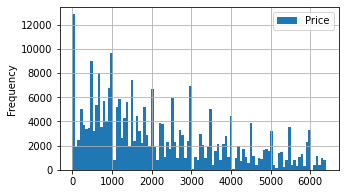

In [7]:
df.plot (y = 'Price', kind = 'hist', bins = 100, grid=True, figsize = (5,3), range = (0,6400))

Есть значения цены около 0, посмотрим внимательно на них

<AxesSubplot:ylabel='Frequency'>

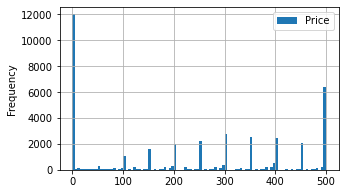

In [8]:
df.plot (y = 'Price', kind = 'hist', bins = 100, grid=True, figsize = (5,3), range = (0,500))

Т.к. для наших прогнозов цена является целевым признаком, то для последующих обучений моделей такой результат неприемлим, потому необходимо избавиться от объявлений без указания цены и цены менее 50 евро

In [9]:
df = df.query('Price >= 50')

Рассмотрим следующие столбцы VehicleType, Gearbox, Model, FuelType.

Т.к. во всех из них есть пропуски данных и их мы не можем восстановить по какому-нибудь похожему признаку, потому как в разные годы (и в течении одного года выпуска) автомобили одной марки могли выпускаться с разными типами кузовов, с разными коробками передач, с разными двигателями и типом топлива заменим пропущенные значения на 'unknown'

Аналогичная ситуация и со столбцом NotRepaired.

Из-за отсутствия данных, мы не можем подставить туда ни да ни нет.

In [10]:
df['VehicleType'].fillna('unknown', inplace = True)
df['Gearbox'].fillna('unknown', inplace = True)
df['Model'].fillna('unknown', inplace = True)
df['FuelType'] = df['FuelType'].replace({'petrol' : 'gasoline'})
df['FuelType'].fillna('unknown', inplace = True)
df['NotRepaired'].fillna('unknown', inplace = True)

Рассмотрим данные в столбце Power

In [11]:
df['Power'].describe()

count    341946.000000
mean        111.207240
std         188.253725
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Видим нулевые значения и максимальное количество авто по мощности сконцентрировано в диапазоне от 0 до 250. Рассмотрим распределение.

<AxesSubplot:ylabel='Frequency'>

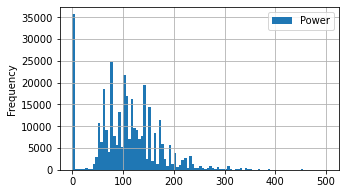

In [12]:
df.plot (y = 'Power', kind = 'hist', bins = 100, grid=True, figsize = (5,3), range = (0,500))

Мы видим, что много значений с нулевой мощностью и единичные значения с мощностью более 400-т. Заменить мы их ничем не сможем, поэтому избавимся от них.

In [13]:
df = df.query('0 < Power < 400')

Рассмотрим данные в столбце RegistrationYear

In [14]:
df['RegistrationYear'].describe()

count    305671.000000
mean       2003.481472
std          29.156012
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Видим, что данные начинаются с 1000 года по 9999 год. Посмотрим поближе

<AxesSubplot:ylabel='Frequency'>

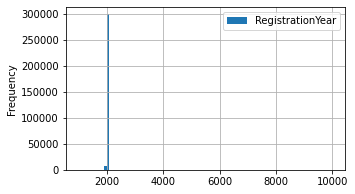

In [15]:
df.plot (y = 'RegistrationYear', kind = 'hist', bins = 100, grid=True, figsize = (5,3), range = (1000,9999))

Концентрация данных по году выпуска сосредоточена около 2000 годов

<AxesSubplot:ylabel='Frequency'>

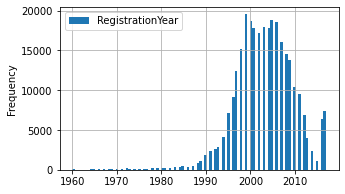

In [16]:
df.plot (y = 'RegistrationYear', kind = 'hist', bins = 100, grid=True, figsize = (5,3), range = (1960,2017))

Данные вне диапазона 1960 -2017 либо ошибки при внесении либо вбросы. Даже, если это невбросы, масовый сегмент предсказаний мы видим из гистограммы. Избавимся от них

In [17]:
df = df.query('1960 < RegistrationYear < 2017')

В дальнейшем обучении моделей столбец DateCreated не несет никакой смысловой нагрузки, избавимся от него

In [18]:
df = df.drop(['DateCreated'], axis=1)

Удалим дубликаты

In [19]:
df = df.drop_duplicates().reset_index(drop = True)

Посмотрим на полученные данные

In [20]:
first_look(df)

------------- Первые 5 строк ------------


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
1,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
2,1500,small,2001,manual,75,golf,150000,6,gasoline,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,10,gasoline,bmw,yes




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272018 entries, 0 to 272017
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              272018 non-null  int64 
 1   VehicleType        272018 non-null  object
 2   RegistrationYear   272018 non-null  int64 
 3   Gearbox            272018 non-null  object
 4   Power              272018 non-null  int64 
 5   Model              272018 non-null  object
 6   Kilometer          272018 non-null  int64 
 7   RegistrationMonth  272018 non-null  int64 
 8   FuelType           272018 non-null  object
 9   Brand              272018 non-null  object
 10  NotRepaired        272018 non-null  object
dtypes: int64(5), object(6)
memory usage: 22.8+ MB
None


------------- Пропуски ------------
Пропусков НЕТ


------------- Дубликаты ------------
Дубликатов НЕТ











------------- Категориальные признаки ------------


На данном этапе мы ознакомидись с данными, избавились от пустых значений, вбросов и дубликатов

<a id="step_3"></a>
## Обучение моделей

Функция разбиения выборок на обучающую, валидационную и тестовую в соотношении 60:20:20

In [21]:
def split(df):
    features_train, features_test, target_train, target_test = train_test_split(
    df.drop('Price', axis=1), df.Price, test_size=0.25, random_state=12345)
    return features_train, features_test, target_train, target_test

Т.к проверка наших моделей будет осуществляться метрикой RMSE, создадим для нее функцию и определим переменной scorer ссылку на объект с наилучшим результатом

In [22]:
def rmse_score (target, predictions):
    rmse = mean_squared_error(target, predictions)**0.5
    return rmse
scorer = make_scorer(rmse_score, greater_is_better=False)

Функция обучения наших моделей, поиска наилучшей метрики RMSE и подобранных параметров

In [23]:
def model_look (model, parameters, features_train, target_train):
    model_grid = GridSearchCV(model, parameters, cv=5, scoring=scorer, verbose=5)
    model_grid.fit(features_train, target_train)
    return model_grid.best_score_, model_grid.best_params_

Преобразуем категориальные данные методом прямого кодирования для обучения модели линейной регриссии

In [24]:
df_ohe = df.copy
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.head()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,18300,2011,190,125000,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,9800,2004,163,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1500,2001,75,150000,6,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,3600,2008,69,90000,7,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,650,1995,102,150000,10,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [25]:
features_train_lr, features_test_lr, target_train_lr, target_test_lr = split (df_ohe)

<a id="step_4"></a>
Обучим модель линейной регрессии и узнаем лучшую метрику RMSE и параметры

In [26]:
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
rmse, best_parameters = model_look (LinearRegression(), parameters, features_train_lr, target_train_lr)
display('Лучшие параметры модели линейной регрессии:', best_parameters)
display('Дали RMSE модели:', rmse)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .............fit_intercept=True, normalize=True; total time=  13.2s
[CV 2/5] END .............fit_intercept=True, normalize=True; total time=  13.6s
[CV 3/5] END .............fit_intercept=True, normalize=True; total time=  13.2s
[CV 4/5] END .............fit_intercept=True, normalize=True; total time=  13.4s
[CV 5/5] END .............fit_intercept=True, normalize=True; total time=  13.3s
[CV 1/5] END ............fit_intercept=True, normalize=False; total time=  14.2s
[CV 2/5] END ............fit_intercept=True, normalize=False; total time=  13.9s
[CV 3/5] END ............fit_intercept=True, normalize=False; total time=  13.1s
[CV 4/5] END ............fit_intercept=True, normalize=False; total time=  16.0s
[CV 5/5] END ............fit_intercept=True, normalize=False; total time=  14.9s
[CV 1/5] END ............fit_intercept=False, normalize=True; total time=  13.2s
[CV 2/5] END ............fit_intercept=False, nor

'Лучшие параметры модели линейной регрессии:'

{'fit_intercept': True, 'normalize': False}

'Дали RMSE модели:'

-2591.248126856851

In [27]:
results = pd.DataFrame ({'model':['LinearRegression'], 'best_parameters_train':[best_parameters], 'RMSE_train':[rmse]})

In [28]:
results

,model,best_parameters_train,RMSE_train
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-2591.248127


<a id="step_5"></a>
Проверим работу модели предсказаний на моделе дерева решений. Т.к. для деревянных моделей подходит больше кодирование признаков порядковым кодированием, подготовим дланные

In [29]:
cat_columns = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired', 'Brand', 'Model']
encoder = OrdinalEncoder()
df_ordinal = df.copy()
df_ordinal[cat_columns] = encoder.fit_transform(df_ordinal[cat_columns])
df_ordinal.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,18300,2.0,2011,1.0,190,227.0,125000,5,2.0,1.0,2.0
1,9800,6.0,2004,0.0,163,117.0,125000,8,2.0,14.0,1.0
2,1500,5.0,2001,1.0,75,116.0,150000,6,2.0,38.0,0.0
3,3600,5.0,2008,1.0,69,101.0,90000,7,2.0,31.0,0.0
4,650,4.0,1995,1.0,102,11.0,150000,10,2.0,2.0,2.0


In [30]:
features_train_tree, features_test_tree, target_train_tree, target_test_tree\
    = split (df_ordinal)

In [31]:
parameters = {'max_depth': range(19,21), 'min_samples_split': range(45,47)}
rmse, best_parameters = model_look (DecisionTreeRegressor(random_state=12345),\
                                    parameters, features_train_tree, target_train_tree)
display('Лучшие параметры модели дерева решений:', best_parameters)
display('Дали RMSE модели:', rmse)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .............max_depth=19, min_samples_split=45; total time=   0.5s
[CV 2/5] END .............max_depth=19, min_samples_split=45; total time=   0.5s
[CV 3/5] END .............max_depth=19, min_samples_split=45; total time=   0.5s
[CV 4/5] END .............max_depth=19, min_samples_split=45; total time=   0.5s
[CV 5/5] END .............max_depth=19, min_samples_split=45; total time=   0.5s
[CV 1/5] END .............max_depth=19, min_samples_split=46; total time=   0.5s
[CV 2/5] END .............max_depth=19, min_samples_split=46; total time=   0.5s
[CV 3/5] END .............max_depth=19, min_samples_split=46; total time=   0.5s
[CV 4/5] END .............max_depth=19, min_samples_split=46; total time=   0.5s
[CV 5/5] END .............max_depth=19, min_samples_split=46; total time=   0.5s
[CV 1/5] END .............max_depth=20, min_samples_split=45; total time=   0.5s
[CV 2/5] END .............max_depth=20, min_sampl

'Лучшие параметры модели дерева решений:'

{'max_depth': 19, 'min_samples_split': 45}

'Дали RMSE модели:'

-1818.96606439004

In [32]:
results = results.append({'model':'DecisionTreeRegressor', 'best_parameters_train':best_parameters, 'RMSE_train':rmse}, ignore_index=True)
results

,model,best_parameters_train,RMSE_train
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-2591.248127
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064


<a id="step_6"></a>
Проверим работу модели предсказаний на моделе случайного леса

In [33]:
parameters = {'n_estimators': range(143, 146, 1), 'max_depth': range(17,20, 1)}
rmse, best_parameters = model_look (RandomForestRegressor(random_state=12345), \
                                    parameters, features_train_tree, target_train_tree)
display('Лучшие параметры модели случайного леса:', best_parameters)
display('Дали RMSE модели:', rmse)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .................max_depth=17, n_estimators=143; total time=  48.5s
[CV 2/5] END .................max_depth=17, n_estimators=143; total time=  47.9s
[CV 3/5] END .................max_depth=17, n_estimators=143; total time=  47.9s
[CV 4/5] END .................max_depth=17, n_estimators=143; total time=  48.4s
[CV 5/5] END .................max_depth=17, n_estimators=143; total time=  49.9s
[CV 1/5] END .................max_depth=17, n_estimators=144; total time=  49.6s
[CV 2/5] END .................max_depth=17, n_estimators=144; total time=  50.3s
[CV 3/5] END .................max_depth=17, n_estimators=144; total time=  48.7s
[CV 4/5] END .................max_depth=17, n_estimators=144; total time=  48.4s
[CV 5/5] END .................max_depth=17, n_estimators=144; total time=  48.7s
[CV 1/5] END .................max_depth=17, n_estimators=145; total time=  49.3s
[CV 2/5] END .................max_depth=17, n_est

'Лучшие параметры модели случайного леса:'

{'max_depth': 18, 'n_estimators': 144}

'Дали RMSE модели:'

-1632.0294017113279

In [34]:
results = results.append({'model':'RandomForestRegressor', 'best_parameters_train':best_parameters, 'RMSE_train':rmse}, ignore_index=True)
results

,model,best_parameters_train,RMSE_train
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-2591.248127
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1632.029402


<a id="step_7"></a>
Проверим работу модели предсказаний на моделе CatBoostRegressor. Для этого переведем значения категориальных столбцов в тип 'category'

In [35]:
for columns in cat_columns:
    df[columns] = df[columns].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272018 entries, 0 to 272017
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Price              272018 non-null  int64   
 1   VehicleType        272018 non-null  category
 2   RegistrationYear   272018 non-null  int64   
 3   Gearbox            272018 non-null  category
 4   Power              272018 non-null  int64   
 5   Model              272018 non-null  category
 6   Kilometer          272018 non-null  int64   
 7   RegistrationMonth  272018 non-null  int64   
 8   FuelType           272018 non-null  category
 9   Brand              272018 non-null  category
 10  NotRepaired        272018 non-null  category
dtypes: category(6), int64(5)
memory usage: 12.2 MB


In [36]:
features_train, features_test, target_train, target_test\
    = split (df)

In [37]:
parameters = {'depth': range(7, 9, 1), 'iterations': range(1000, 1200, 100)}
rmse, best_parameters = model_look (CatBoostRegressor(cat_features = cat_columns, loss_function="RMSE", \
                                                      learning_rate = 0.5), parameters, features_train, target_train)
display('Лучшие параметры модели CatBoostRegressor:', best_parameters)
display('Дали RMSE модели:', rmse)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0:	learn: 3173.3707569	total: 289ms	remaining: 4m 48s
1:	learn: 2499.3282952	total: 540ms	remaining: 4m 29s
2:	learn: 2205.8928837	total: 764ms	remaining: 4m 13s
3:	learn: 2043.9117930	total: 988ms	remaining: 4m 6s
4:	learn: 1958.3144676	total: 1.2s	remaining: 3m 58s
5:	learn: 1901.6022045	total: 1.34s	remaining: 3m 41s
6:	learn: 1869.6636487	total: 1.51s	remaining: 3m 34s
7:	learn: 1847.0830591	total: 1.7s	remaining: 3m 30s
8:	learn: 1826.2132559	total: 1.88s	remaining: 3m 27s
9:	learn: 1811.8748603	total: 2.09s	remaining: 3m 26s
10:	learn: 1801.6593178	total: 2.24s	remaining: 3m 21s
11:	learn: 1791.2325386	total: 2.43s	remaining: 3m 19s
12:	learn: 1779.7369002	total: 2.62s	remaining: 3m 19s
13:	learn: 1771.4997165	total: 2.84s	remaining: 3m 20s
14:	learn: 1755.0818016	total: 2.98s	remaining: 3m 15s
15:	learn: 1745.7259810	total: 3.2s	remaining: 3m 16s
16:	learn: 1738.1320462	total: 3.39s	remaining: 3m 16s
17:	learn: 1731.991

'Лучшие параметры модели CatBoostRegressor:'

{'depth': 7, 'iterations': 1000}

'Дали RMSE модели:'

-1580.6954819236585

In [38]:
results = results.append({'model':'CatBoostRegressor', 'best_parameters_train':best_parameters, 'RMSE_train':rmse}, ignore_index=True)
results

,model,best_parameters_train,RMSE_train
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-2591.248127
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1632.029402
3,CatBoostRegressor,"{'depth': 7, 'iterations': 1000}",-1580.695482


<a id="step_8"></a>
Проверим работу модели предсказаний на моделе LGBMRegressor.

In [39]:
parameters = {'n_estimators':[1191, 1192]}
rmse, best_parameters = model_look (LGBMRegressor(random_state=12345), parameters, features_train, target_train)
display('Лучшие параметры модели LGBMRegressor:', best_parameters)
display('Дали RMSE модели:', rmse)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ..............................n_estimators=1191; total time= 5.9min
[CV 2/5] END ..............................n_estimators=1191; total time=  33.8s
[CV 3/5] END ..............................n_estimators=1191; total time=  34.1s
[CV 4/5] END ..............................n_estimators=1191; total time=  53.8s
[CV 5/5] END ..............................n_estimators=1191; total time=  32.7s
[CV 1/5] END ..............................n_estimators=1192; total time=  36.8s
[CV 2/5] END ..............................n_estimators=1192; total time=  32.9s
[CV 3/5] END ..............................n_estimators=1192; total time=  32.3s
[CV 4/5] END ..............................n_estimators=1192; total time=  32.3s
[CV 5/5] END ..............................n_estimators=1192; total time=  38.0s


'Лучшие параметры модели LGBMRegressor:'

{'n_estimators': 1191}

'Дали RMSE модели:'

-1538.0788462015475

In [40]:
results = results.append({'model':'LGBMRegressor', 'best_parameters_train':best_parameters, 'RMSE_train':rmse}, ignore_index=True)
results

,model,best_parameters_train,RMSE_train
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-2591.248127
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1632.029402
3,CatBoostRegressor,"{'depth': 7, 'iterations': 1000}",-1580.695482
4,LGBMRegressor,{'n_estimators': 1191},-1538.078846


На данном этапе мы выяснили какую метрику получают модели предсказаний и их лучшие параментры. Необходимо все это проверить на тестовой выборке

<a id="step_9"></a>
## Анализ моделей

Создадим функцию для обучения, хронометража обучения и предсказания моделей

In [41]:
def ml_result(model, features_train, target_train, features_test, target_test):
        
    fit_up = time.time()
    model.fit(features_train, target_train)
    fit_down = time.time()
    
    fit_time = fit_down - fit_up
    
    predict_up = time.time()
    predictions = model.predict(features_test)
    predict_down = time.time()
    
    predict_time = predict_down - predict_up
    
    rmse = mean_squared_error(target_test, predictions)**0.5
      
    return fit_time, predict_time, rmse

Проверим модель линейной регрессии

In [42]:
fit_time, predict_time, rmse = ml_result(LinearRegression(fit_intercept=True, normalize=False), features_train_lr, \
                                         target_train_lr, features_test_lr, target_test_lr)
results.loc[0, 'fit_time'] = fit_time
results.loc[0, 'predict_time'] = predict_time
results.loc[0, 'rmse_test'] = rmse
results

,model,best_parameters_train,RMSE_train,fit_time,predict_time,rmse_test
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-2591.248127,16.885057,0.237754,2569.973433
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064,NaN,NaN,NaN
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1632.029402,NaN,NaN,NaN
3,CatBoostRegressor,"{'depth': 7, 'iterations': 1000}",-1580.695482,NaN,NaN,NaN
4,LGBMRegressor,{'n_estimators': 1191},-1538.078846,NaN,NaN,NaN


Проверим модель дерева решений

In [43]:
fit_time, predict_time, rmse = ml_result(DecisionTreeRegressor(random_state=12345, max_depth=19, min_samples_split=45), \
                                         features_train_tree, target_train_tree, features_test_tree, target_test_tree)
results.loc[1, 'fit_time'] = fit_time
results.loc[1, 'predict_time'] = predict_time
results.loc[1, 'rmse_test'] = rmse
results

,model,best_parameters_train,RMSE_train,fit_time,predict_time,rmse_test
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-2591.248127,16.885057,0.237754,2569.973433
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064,0.590328,0.015045,1767.001566
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1632.029402,NaN,NaN,NaN
3,CatBoostRegressor,"{'depth': 7, 'iterations': 1000}",-1580.695482,NaN,NaN,NaN
4,LGBMRegressor,{'n_estimators': 1191},-1538.078846,NaN,NaN,NaN


Проверим модель случайного дерева

In [44]:
fit_time, predict_time, rmse = ml_result(RandomForestRegressor(random_state=12345, max_depth=18, n_estimators=144), \
                                         features_train_tree, target_train_tree, features_test_tree, target_test_tree)
results.loc[2, 'fit_time'] = fit_time
results.loc[2, 'predict_time'] = predict_time
results.loc[2, 'rmse_test'] = rmse
results

,model,best_parameters_train,RMSE_train,fit_time,predict_time,rmse_test
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-2591.248127,16.885057,0.237754,2569.973433
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064,0.590328,0.015045,1767.001566
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1632.029402,64.569116,2.331707,1590.737111
3,CatBoostRegressor,"{'depth': 7, 'iterations': 1000}",-1580.695482,NaN,NaN,NaN
4,LGBMRegressor,{'n_estimators': 1191},-1538.078846,NaN,NaN,NaN


Проверим модель CatBoostRegressor

In [45]:
fit_time, predict_time, rmse = ml_result(CatBoostRegressor(cat_features=cat_columns, loss_function="RMSE", \
                                                           learning_rate = 0.5, depth=7, iterations=1000), \
                                         features_train, target_train, features_test, target_test)
results.loc[3, 'fit_time'] = fit_time
results.loc[3, 'predict_time'] = predict_time
results.loc[3, 'rmse_test'] = rmse
results

0:	learn: 3196.5809546	total: 333ms	remaining: 5m 32s
1:	learn: 2537.4509001	total: 651ms	remaining: 5m 24s
2:	learn: 2204.5122682	total: 944ms	remaining: 5m 13s
3:	learn: 2053.8749254	total: 1.19s	remaining: 4m 57s
4:	learn: 1973.3740721	total: 1.41s	remaining: 4m 41s
5:	learn: 1931.3642871	total: 1.61s	remaining: 4m 26s
6:	learn: 1900.5600310	total: 1.89s	remaining: 4m 28s
7:	learn: 1866.6729251	total: 2.06s	remaining: 4m 15s
8:	learn: 1850.7347759	total: 2.27s	remaining: 4m 9s
9:	learn: 1827.9880080	total: 2.47s	remaining: 4m 4s
10:	learn: 1815.3702541	total: 2.76s	remaining: 4m 7s
11:	learn: 1799.5965553	total: 3.03s	remaining: 4m 9s
12:	learn: 1787.9055276	total: 3.27s	remaining: 4m 8s
13:	learn: 1779.0813524	total: 3.52s	remaining: 4m 8s
14:	learn: 1769.3587678	total: 3.75s	remaining: 4m 6s
15:	learn: 1761.5424677	total: 4s	remaining: 4m 6s
16:	learn: 1752.8230315	total: 4.25s	remaining: 4m 5s
17:	learn: 1747.8382730	total: 4.52s	remaining: 4m 6s
18:	learn: 1741.9063038	total: 4.

,model,best_parameters_train,RMSE_train,fit_time,predict_time,rmse_test
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-2591.248127,16.885057,0.237754,2569.973433
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064,0.590328,0.015045,1767.001566
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1632.029402,64.569116,2.331707,1590.737111
3,CatBoostRegressor,"{'depth': 7, 'iterations': 1000}",-1580.695482,257.644511,0.897260,1552.117225
4,LGBMRegressor,{'n_estimators': 1191},-1538.078846,NaN,NaN,NaN


Проверим модель LGBMRegressor

In [46]:
fit_time, predict_time, rmse = ml_result(LGBMRegressor(random_state=12345, n_estimators=1191), \
                                         features_train, target_train, features_test, target_test)
results.loc[4, 'fit_time'] = fit_time
results.loc[4, 'predict_time'] = predict_time
results.loc[4, 'rmse_test'] = rmse
results

,model,best_parameters_train,RMSE_train,fit_time,predict_time,rmse_test
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-2591.248127,16.885057,0.237754,2569.973433
1,DecisionTreeRegressor,"{'max_depth': 19, 'min_samples_split': 45}",-1818.966064,0.590328,0.015045,1767.001566
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 144}",-1632.029402,64.569116,2.331707,1590.737111
3,CatBoostRegressor,"{'depth': 7, 'iterations': 1000}",-1580.695482,257.644511,0.897260,1552.117225
4,LGBMRegressor,{'n_estimators': 1191},-1538.078846,510.205598,9.442649,1507.442901


<a id="step_10"></a>
Вывод по данному этапу:

На данном этапе мы проверили наши модели с полученными ранее гиперпараметрами на тесвой выборке.

Лучшая с точки зрения качества предсказания - модель LGBMRegressor

Наименьшее время обучения - модель DecisionTreeRegressor

Наменьшее время предсказания - модель DecisionTreeRegressor

<a id="step_11"></a>
## Общий вывод

По полученным результатам я бы рекомендовал модель LGBMRegressor, как соотношение качества предсказания ко времени обучения и предсказания.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей